In [1]:
# main.ipynb

# import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from torchvision.models import resnet50, resnet101, ResNet50_Weights, ResNet101_Weights
from torchvision.models.quantization import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')


using device: cuda


In [2]:
# data preprocessing and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet的均值和标准差
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet的均值和标准差
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [3]:
# Custom dataset class
class LeafDataset(Dataset):
    def __init__(self, csv_file, transform=None, mode='train'):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode  # 'train' or 'test'

        if self.mode == 'train':
            # extract labels and encode
            self.le = LabelEncoder()
            self.data['label'] = self.le.fit_transform(self.data['label'])
            self.classes = self.le.classes_
        else:
            self.classes = None  # test set has no labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join('..', self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.mode == 'train':
            label = self.data.iloc[idx, 1]
            return image, label
        else:
            return image, self.data.iloc[idx, 0]  # return image and file name


In [4]:
# 加载训练数据集
train_csv = '../train.csv'
train_dataset = LeafDataset(csv_file=train_csv, transform=data_transforms['train'], mode='train')

num_classes = len(train_dataset.classes)
print(f'class number: {num_classes}')


class number: 176


In [5]:
# prepare K-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# training parameters
num_epochs = 10
batch_size = 128
learning_rate = 0.008
criterion = nn.CrossEntropyLoss()
torch.backends.cudnn.benchmark = True
num_workers = 8
checkpoint_dir = '../checkpoints'
model_name = 'resnet50' # or resnet101

In [6]:
# define training and validation function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, fold):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Fold {fold}, Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                # zero parameter gradients
                optimizer.zero_grad()

                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backpropagation + optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # learning rate adjustment
            if phase == 'train':
                scheduler.step()

            # calculate loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Fold {fold} finished in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best validation accuracy: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc


In [7]:
# start K-fold cross validation
fold_results = {}
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold}')
    print('-' * 20)

    # create data subsets
    train_subsampler = Subset(train_dataset, train_idx)
    val_subsampler = Subset(train_dataset, val_idx)

    # data loaders
    dataloaders = {
        'train': DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, pin_memory=True),
        'val': DataLoader(val_subsampler, batch_size=batch_size, shuffle=False, pin_memory=True)
    }

    # initialize model
    # model_list = [
    #     {'name': 'resnet50', 'model_fn': resnet50, 'weights': ResNet50_Weights.DEFAULT},
    #     {'name': 'resnet101', 'model_fn': resnet101, 'weights': ResNet101_Weights.DEFAULT},
    # ]
    if model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
    else:
        raise ValueError(f'Unsupported model: {model_name}')

    # modify the last fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)

    # set optimizer and learning rate scheduler
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # reduce learning rate by 0.1 every 7 epochs
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # train and evaluate
    model, best_acc = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs, fold)

    # save the best model for each fold
    model_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_save_path = os.path.join(model_dir, f'model_fold_{fold}.pth')
    torch.save(model.state_dict(), model_save_path)

    # store results
    fold_results[fold] = {'model': model, 'best_acc': best_acc}


Fold 0
--------------------
Fold 0, Epoch 0/9
----------
Train Loss: 4.4075 Acc: 0.1214
Val Loss: 2.4667 Acc: 0.3811

Fold 0, Epoch 1/9
----------
Train Loss: 1.4517 Acc: 0.6204
Val Loss: 0.9195 Acc: 0.7401

Fold 0, Epoch 2/9
----------
Train Loss: 0.6377 Acc: 0.8201
Val Loss: 0.6214 Acc: 0.8178

Fold 0, Epoch 3/9
----------
Train Loss: 0.3890 Acc: 0.8905
Val Loss: 0.4792 Acc: 0.8510

Fold 0, Epoch 4/9
----------
Train Loss: 0.2761 Acc: 0.9187
Val Loss: 0.3852 Acc: 0.8788

Fold 0, Epoch 5/9
----------
Train Loss: 0.2001 Acc: 0.9429
Val Loss: 0.2998 Acc: 0.9049

Fold 0, Epoch 6/9
----------
Train Loss: 0.1566 Acc: 0.9556
Val Loss: 0.2564 Acc: 0.9202

Fold 0, Epoch 7/9
----------
Train Loss: 0.1034 Acc: 0.9751
Val Loss: 0.2053 Acc: 0.9349

Fold 0, Epoch 8/9
----------
Train Loss: 0.0846 Acc: 0.9786
Val Loss: 0.1986 Acc: 0.9379

Fold 0, Epoch 9/9
----------
Train Loss: 0.0827 Acc: 0.9792
Val Loss: 0.1949 Acc: 0.9371

Fold 0 finished in 13m 15s
best validation accuracy: 0.9379
Fold 1
-----

In [8]:
# all folds training completed
print('all folds training completed.')

all folds training completed.


In [9]:
# select the best model
best_fold = max(fold_results, key=lambda x: fold_results[x]['best_acc'])
best_model = fold_results[best_fold]['model']
print(f'best model from Fold {best_fold}, validation accuracy: {fold_results[best_fold]["best_acc"]:.4f}')

best model from Fold 3, validation accuracy: 0.9414


In [10]:
# load test set
test_csv = '../test.csv'
test_dataset = LeafDataset(csv_file=test_csv, transform=data_transforms['test'], mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# use the best model for prediction
best_model.eval()
all_preds = []
image_names = []
with torch.no_grad():
    for inputs, img_paths in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        image_names.extend(img_paths)

# map predicted labels back to original labels
label_encoder = train_dataset.le  # get LabelEncoder from training set
predicted_labels = label_encoder.inverse_transform(all_preds)

# create submission file
submission = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})

# save as CSV file
result_path = os.path.join(checkpoint_dir, model_name, 'sample_submission.csv')
submission.to_csv(result_path, index=False)
print('prediction results saved to sample_submission.csv')

prediction results saved to sample_submission.csv


In [11]:
# load test set
test_csv = '../test.csv'  # please adjust the path according to实际情况
test_dataset = LeafDataset(csv_file=test_csv, transform=data_transforms['test'], mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# use 5-fold models for prediction and voting
from collections import Counter

# ensure all models are in evaluation mode and loaded to GPU
for fold in fold_results:
    fold_results[fold]['model'].eval()
    fold_results[fold]['model'] = fold_results[fold]['model'].to(device)

# store prediction results of each model
all_fold_preds = []

with torch.no_grad():
    for inputs, img_paths in test_loader:
        inputs = inputs.to(device)
        # store prediction results of each model in current batch
        batch_fold_preds = []

        # for each model, get prediction results
        for fold in fold_results:
            model = fold_results[fold]['model']
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            batch_fold_preds.append(preds.cpu().numpy())

        # transpose all model prediction results, so each element corresponds to all model predictions for a sample
        batch_fold_preds = np.array(batch_fold_preds)  # Shape: (num_folds, batch_size)
        batch_fold_preds = batch_fold_preds.T  # Shape: (batch_size, num_folds)

        # for each sample, perform voting
        final_preds = []
        for preds_per_sample in batch_fold_preds:
            # count occurrences of each class
            vote_counts = Counter(preds_per_sample)
            # find the class with the most occurrences
            most_common = vote_counts.most_common(1)[0][0]
            final_preds.append(most_common)

        # store final prediction results for current batch
        all_fold_preds.extend(final_preds)

# map predicted labels back to original labels
label_encoder = train_dataset.le  # get LabelEncoder from training set
predicted_labels = label_encoder.inverse_transform(all_fold_preds)

# get image names from test set
image_names = test_dataset.data['image'].tolist()

# create submission file
submission = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})

# save as CSV file
result_path = os.path.join(checkpoint_dir, model_name, 'sample_submission-5fold.csv')
submission.to_csv(result_path, index=False)
print('prediction results saved to sample_submission-5fold.csv')


prediction results saved to sample_submission-5fold.csv


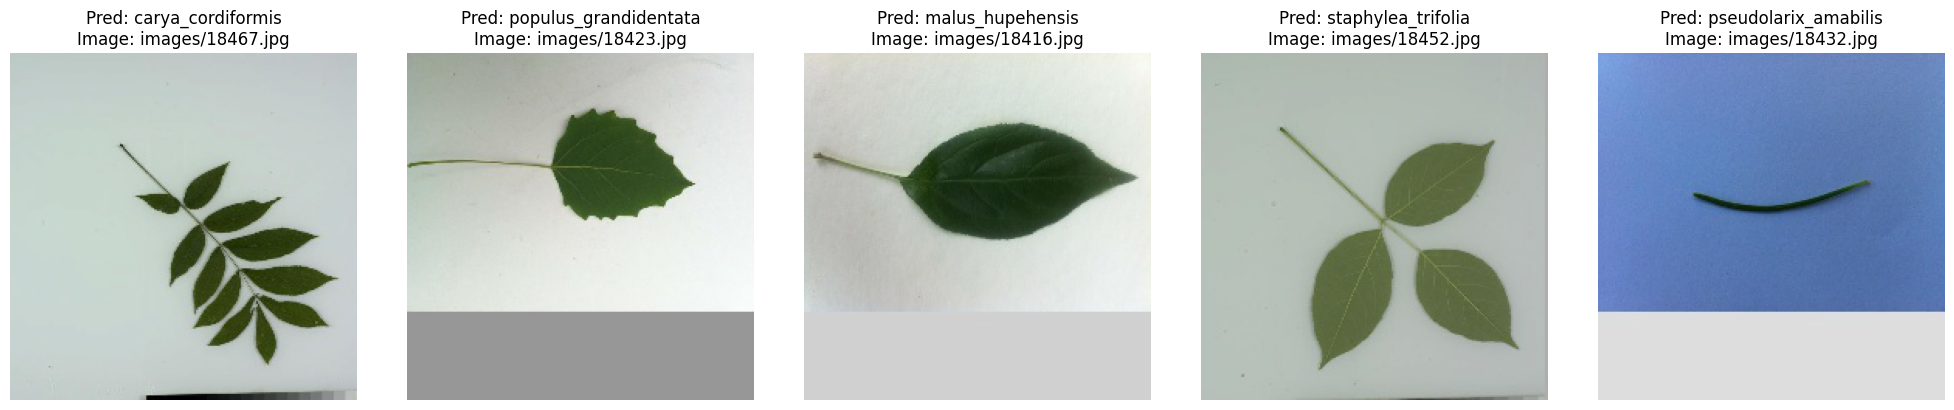

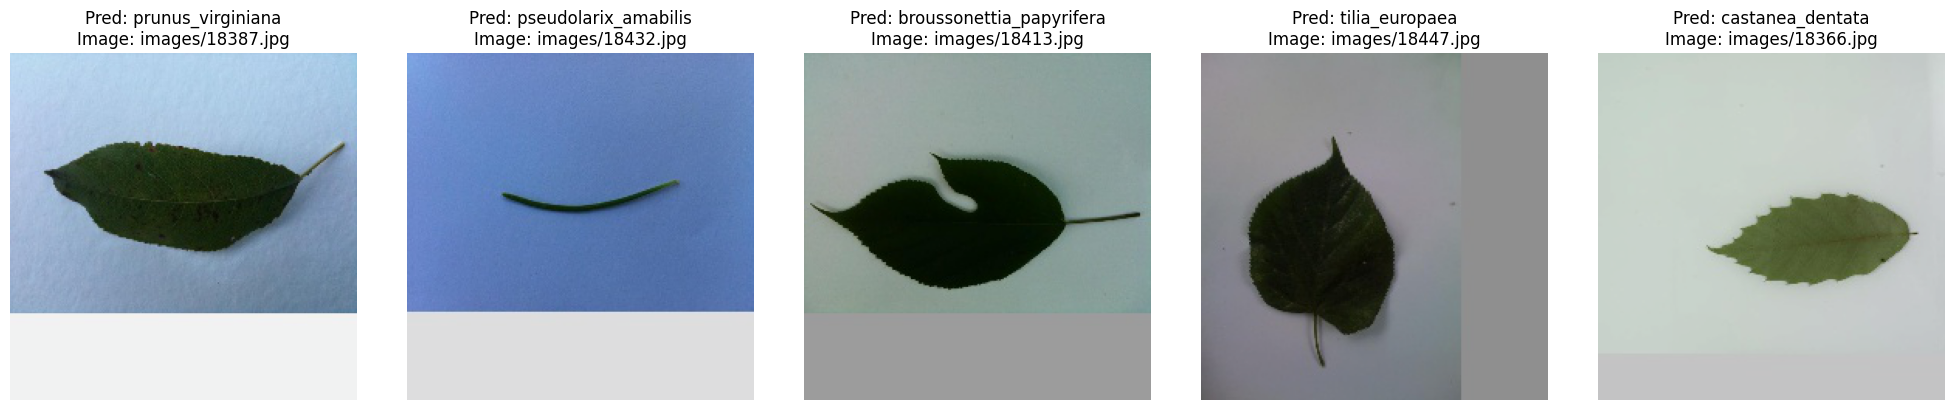

In [13]:
# Visualize random inference results with ground truth
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, test_loader, num_samples=5):
    # Get a random batch
    inputs, img_paths = next(iter(test_loader))
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    # Convert predictions to original labels
    pred_labels = label_encoder.inverse_transform(preds.cpu().numpy())
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    # Randomly select samples
    indices = random.sample(range(len(inputs)), num_samples)
    
    for idx, ax in enumerate(axes):
        sample_idx = indices[idx]
        
        # Get image and denormalize
        img = inputs[sample_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        ax.imshow(img)
        ax.set_title(f'Pred: {pred_labels[sample_idx]}\nImage: {img_paths[sample_idx]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions from the best model
visualize_predictions(best_model, test_loader, num_samples=5)

# Visualize predictions from all models (ensemble)
def visualize_ensemble_predictions(fold_results, test_loader, num_samples=5):
    # Get a random batch
    inputs, img_paths = next(iter(test_loader))
    
    # Get predictions from all models
    all_preds = []
    for fold in fold_results:
        model = fold_results[fold]['model']
        model.eval()
        with torch.no_grad():
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
    
    # Convert to numpy array and transpose
    all_preds = np.array(all_preds)  # Shape: (num_folds, batch_size)
    all_preds = all_preds.T  # Shape: (batch_size, num_folds)
    
    # Get final predictions through voting
    final_preds = []
    for preds_per_sample in all_preds:
        vote_counts = Counter(preds_per_sample)
        most_common = vote_counts.most_common(1)[0][0]
        final_preds.append(most_common)
    
    # Convert to original labels
    pred_labels = label_encoder.inverse_transform(final_preds)
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    # Randomly select samples
    indices = random.sample(range(len(inputs)), num_samples)
    
    for idx, ax in enumerate(axes):
        sample_idx = indices[idx]
        
        # Get image and denormalize
        img = inputs[sample_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        ax.imshow(img)
        ax.set_title(f'Pred: {pred_labels[sample_idx]}\nImage: {img_paths[sample_idx]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize ensemble predictions
visualize_ensemble_predictions(fold_results, test_loader, num_samples=5)

Visualizing predictions from the best model:


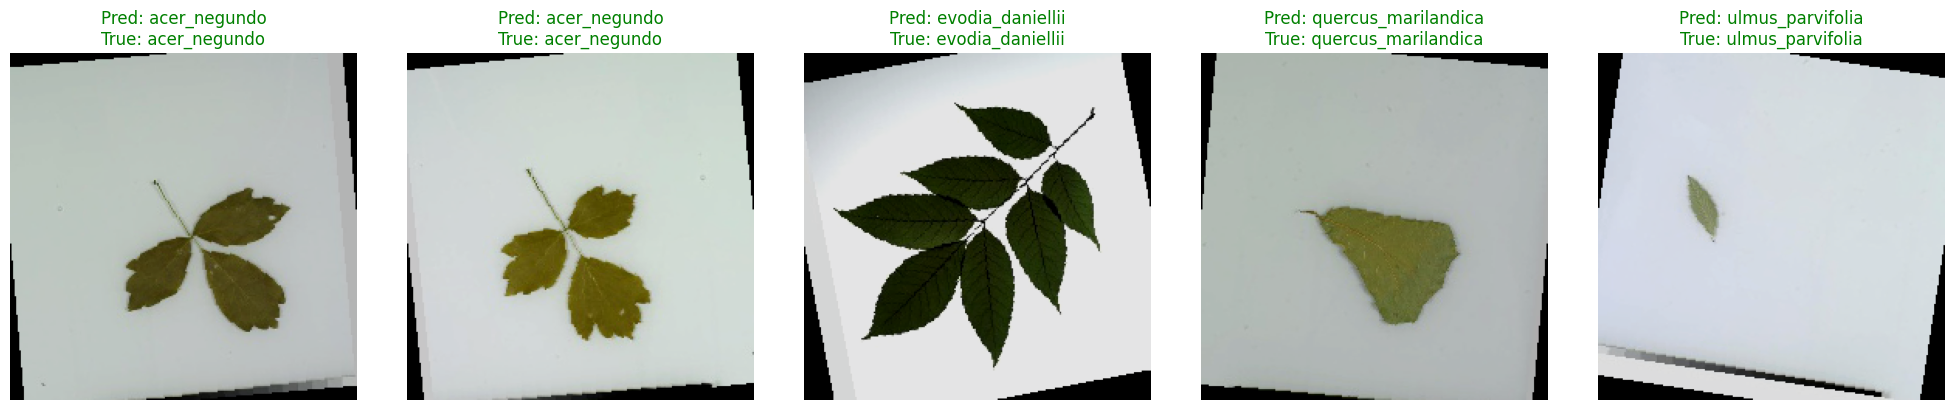


Visualizing predictions from ensemble model:


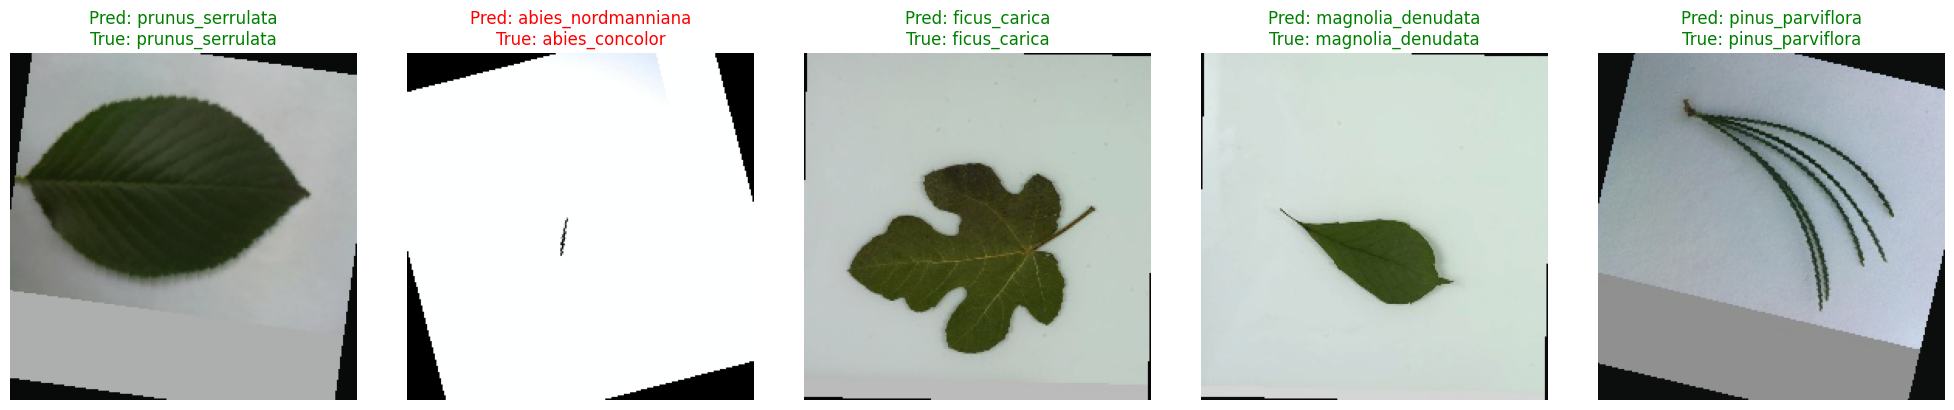

In [14]:
# Visualize random inference results with ground truth
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, train_loader, num_samples=5):
    # Get a random batch
    inputs, labels = next(iter(train_loader))
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    # Convert predictions and ground truth to original labels
    pred_labels = label_encoder.inverse_transform(preds.cpu().numpy())
    true_labels = label_encoder.inverse_transform(labels.cpu().numpy())
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    # Randomly select samples
    indices = random.sample(range(len(inputs)), num_samples)
    
    for idx, ax in enumerate(axes):
        sample_idx = indices[idx]
        
        # Get image and denormalize
        img = inputs[sample_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        ax.imshow(img)
        # Add color coding for correct/incorrect predictions
        color = 'green' if pred_labels[sample_idx] == true_labels[sample_idx] else 'red'
        ax.set_title(f'Pred: {pred_labels[sample_idx]}\nTrue: {true_labels[sample_idx]}', 
                    color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create a DataLoader for training data with shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Visualize predictions from the best model
print("Visualizing predictions from the best model:")
visualize_predictions(best_model, train_loader, num_samples=5)

# Visualize predictions from all models (ensemble)
def visualize_ensemble_predictions(fold_results, train_loader, num_samples=5):
    # Get a random batch
    inputs, labels = next(iter(train_loader))
    
    # Get predictions from all models
    all_preds = []
    for fold in fold_results:
        model = fold_results[fold]['model']
        model.eval()
        with torch.no_grad():
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
    
    # Convert to numpy array and transpose
    all_preds = np.array(all_preds)  # Shape: (num_folds, batch_size)
    all_preds = all_preds.T  # Shape: (batch_size, num_folds)
    
    # Get final predictions through voting
    final_preds = []
    for preds_per_sample in all_preds:
        vote_counts = Counter(preds_per_sample)
        most_common = vote_counts.most_common(1)[0][0]
        final_preds.append(most_common)
    
    # Convert to original labels
    pred_labels = label_encoder.inverse_transform(final_preds)
    true_labels = label_encoder.inverse_transform(labels.cpu().numpy())
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    # Randomly select samples
    indices = random.sample(range(len(inputs)), num_samples)
    
    for idx, ax in enumerate(axes):
        sample_idx = indices[idx]
        
        # Get image and denormalize
        img = inputs[sample_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        ax.imshow(img)
        # Add color coding for correct/incorrect predictions
        color = 'green' if pred_labels[sample_idx] == true_labels[sample_idx] else 'red'
        ax.set_title(f'Pred: {pred_labels[sample_idx]}\nTrue: {true_labels[sample_idx]}', 
                    color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nVisualizing predictions from ensemble model:")
visualize_ensemble_predictions(fold_results, train_loader, num_samples=5)